## Table of Contents

* [Satellite Image Time-Series](#Satellite-Image-Time-Series)
* [Training Labels and Time-Series Satellite Imagery](#Training-Labels-and-Time-Series-Satellite-Imagery)
* [Time-Series Classification](#Time-Series-Classification)
  * [Pixel-Set Encoder](#Pixel-Set-Encoder)
  * [Temporal Attention Encoder](#Temporal-Attention-Encoder)
  * [Spectro-temporal classifier](#Spectro-temporal-classifier)
* [Implementation in arcgis.learn](#Implementation-in-arcgis.learn) 
* [Summary](#Summary)
* [References](#References)

## Satellite Image Time-Series

Time-series of earth observation data is referred to us collection of satellite images of a location from different time-periods, stacked along the time axis resulting in a 3 dimensional structure. The collection have a common projection and a consistent timeline. Each location in the space-time is a vector of values across a timeline as shown in figure 1.

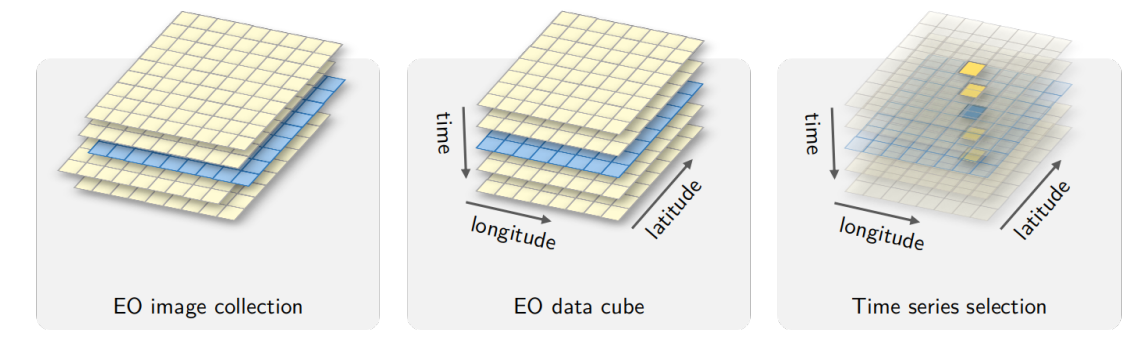

<center> Figure 1. Time-series of satellite imagery </center>

Combination of temporal component with spectral information allow for detection and classification of complex pattern in various applications such as crop type and condition classification, mineral and land-cover mapping etc

In this guide, we will focus on PSETAE, a transformer based deep learning model originally developed by [Garnot et al](https://openaccess.thecvf.com/content_CVPR_2020/papers/Garnot_Satellite_Image_Time_Series_Classification_With_Pixel-Set_Encoders_and_Temporal_CVPR_2020_paper.pdf) for agricultural parcels classification into different crop types in satellite image time-series.

## Training Labels and Time-Series Satellite Imagery

The `Export Training Data for Deep Learning` is used to export training data for the model. The input satellite time-series is a `composite` of rasters from the required time periods or time steps. 

Training labels can be created using the `Label objects for deep learning` tool available inside `Classification Tools`. Pixels are labelled with class based on the available information. As shown in figure are labelling of different crop types. 

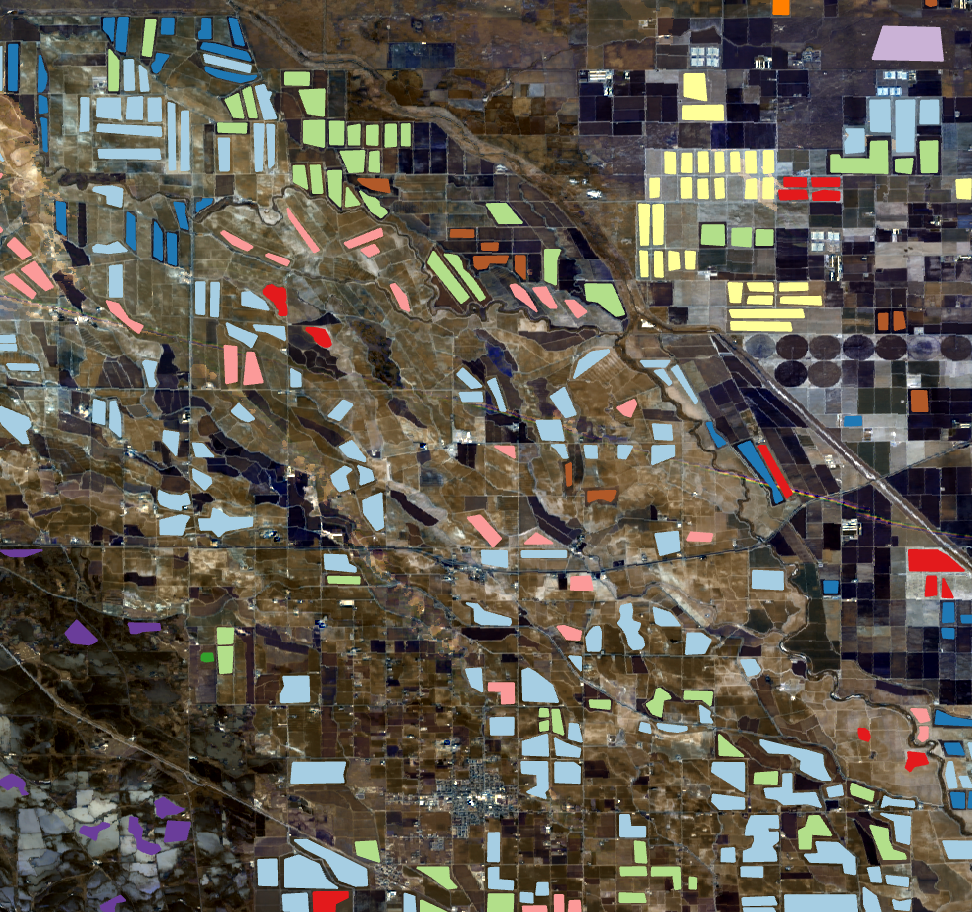

<center> Figure 2. Samples of labels from different classes overlayed on time-series raster  </center> 

## Time-Series Classification

PSETAE architecure is based on transfomers, originally developed for sequence-to-sequence modeling. The proposed architecture encodes time-series of multi-spectral images. The pixels under each class label is given by spectro-temporal tensor of size T x C x N, where T the number of temporal observation, C the number of spectral channels, and N the number of pixels.  

The architecture of pse-tae consists of a pixel-set encoder, temporal attention encoder and, classifier. The components are briefly described in following sections

## Model architecture

### Pixel-Set Encoder

The study suggests that, convolution operations may not be suitable for detection the various classes from images with high spectral variations across time. CNNs were also observed to be memory intensive.

To overcome this issue, the authors proposed pixel-set encoder (PSE). PSE uses the samples pixels from time-series raster, which is processed through a series of shared MLP(Fully Connected, Batch Norms, Rectified Linear Units) layers. This results in the architecture learning about the statistical descriptors of the particular class pixel's spectral distribution. The output is a spectral embedding for set a pixels of a class at time t.

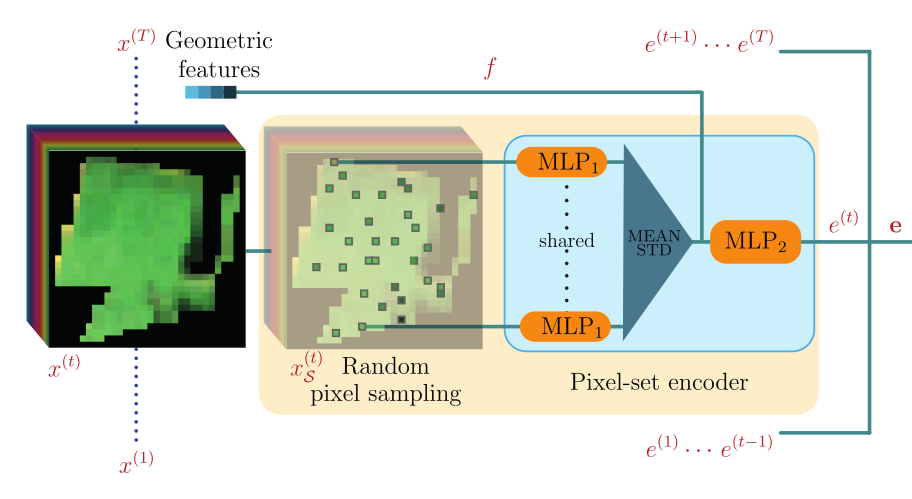

<center> Figure 3. Pixel-Set Encoder </center> 

### Temporal Attention Encoder

This component is based on the state of the art transformer used originally for dealing with sequential data from [Vaswani et al.](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). After multi-channel spectral embedding at time t by pse, the temporal attention encoder (tae) tries to find embedding for each class time-series. The authors made the following changes to original transformers:

- The pre-trained word embedding model used in the original mode is replaced by PSE's spectral embedding.
- The positional encoder uses the first obervation or date to calculate number of days to other dates. This helps the model to take in account the variance in temporal observations.
- As the goal was to encode the whole time-series into single embedding, rather then output for each element of sequence. Query tensors generated by the each attention heads are pooled into single master query.

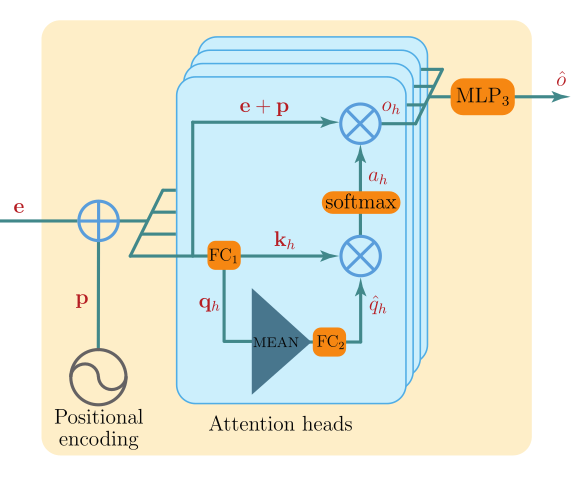

<center> Figure 4. Temporal Attention Encoder </center> 

### Spectro-temporal classifier

Shared PSE embeds all input time-series rasters in parallel and resulting embedded sequence is processed by temporal encoder. The resulting embedding is processed by an mlp to produice class logits. Spectro-temporal classifier combines PSE and TAE with a final MLP layer to produce class logits. 

For further information on the model's architecture, refer to paper

## Implementation in  `arcgis.learn`

Input Raster - Initially, time-series raster is created using `Composite Bands` tool 

Export - use the composited raster as input raster to export the raster chips in `RCNN Masks` metadata format using `Export Training data for deep learning` tool available in `ArcGIS Pro`.

The resulting path is provided to `prepare_data` function in `arcgis.learn` to create a databunch.

`data = prepare_data(path=r"path/to/exported/data", n_temporal, min_points, batch_size, n_temporal_dates, dataset_type="PSETAE")`
                    
where,

* n_temporal - *Number of temporal observations or time steps or number of composited rasters*.
* min_points - *Number of pixels equal to or multiples of 64 to sample from the each labelled region of training data i.e. 64, 128 etc*
* batch_size - *suggested batch size for this model is around 128*
* n_temporal_dates - *The dates of the observations will be used for the positional encoding and should be stored as a list of dates strings in YYYY-MM-DD format. For example, If we have stacked imagery of n bands each from two dates then, ['YYYY-MM-DD','YYYY-MM-DD'].*

By default, initialization of the `PSETAE` object as shown below:

`model = arcgis.learn.PSETAE(data=data)`

Here data is the object returned from `prepare_data` function.

Than, the basic `arcgis.learn` workflow can be followed.

For more information about the API & model applications, please go to the [API reference](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

## Summary 

In this guide, we learned about the various details of the psetae model, its working and how we can initialize the model in `arcgis.learn`

## References

- Garnot, Vivien Sainte Fare, Loic Landrieu, Sebastien Giordano, and Nesrine Chehata. "Satellite image time series classification with pixel-set encoders and temporal self-attention." In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 12325-12334. 2020.
- Simoes, Rolf, Gilberto Camara, Gilberto Queiroz, Felipe Souza, Pedro R. Andrade, Lorena Santos, Alexandre Carvalho, and Karine Ferreira. "Satellite image time series analysis for big earth observation data." Remote Sensing 13, no. 13 (2021): 2428.